# 2023-09-20 · STA conntest for diff recording quality n durations 

In [1]:
include("lib/Nto1.jl")

using Revise … ✔ (0.3 s)
using Units, Nto1AdEx, ConnectionTests, ConnTestEval, MemDiskCache … ✔ (0.4 s)
using StatsBase … ✔ (0.2 s)


In [2]:
N = 6500
duration = 10minutes
@time sim = Nto1AdEx.sim(N, duration);  # ceil_spikes is true by default

  3.204986 seconds (2.10 M allocations: 1.024 GiB, 2.30% gc time, 42.37% compilation time)


## VI noise

In [3]:
(; Vₛ, Eₗ) = Nto1AdEx

function VI_sig(sim; spike_SNR = 10, spike_height = (Vₛ - Eₗ), seed=1)
    Random.seed!(seed)
    σ = spike_height / spike_SNR
    sig = copy(sim.V)
    sig .+= (σ .* randn(length(sig)))
    sig
end;

sig = VI_sig(sim);

In [4]:
include("lib/plot.jl")

import PythonCall … ✔ (2 s)
import PythonPlot … ✔ (3.5 s)
using Sciplotlib … ✔ (0.5 s)
using PhDPlots … ✔


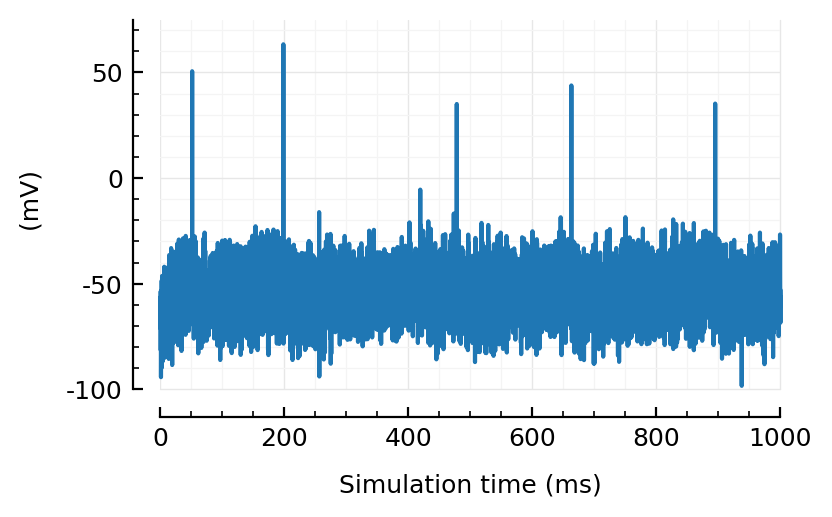

In [5]:
plotsig(sig, [0,1000], ms, yunit=:mV);

Very good.

In [6]:
VI_sig(sim, spike_SNR=Inf) == sim.V

true

Excellent.

## Clip the VI sig

In [7]:
include("lib/df.jl")

using DataFrames … ✔ (0.9 s)


In [8]:
ps = [95, 98, 99, 99.9, 99.95, 99.99, 100]
qs = percentile(sig, ps)
df = DataFrame("p" => ps, "V (mV)" => qs/mV)

Row,p,V (mV)
,Float64,Float64
1,95,-36.5
2,98,-32.1
3,99,-29.1
4,99.9,-19.1
5,100,-11.2
6,100,48.6
7,100,83.5


For the clean (no VI noise) signal, we clipped at -49.79 mV (which was there the 99 percentile)

If we do same:

In [9]:
clip!(sig, p = 99) = begin
    thr = percentile(sig, p)
    to_clip = sig .≥ thr
    sig[to_clip] .= thr
    sig
end;

In [10]:
sigc = clip!(copy(sig), 99);

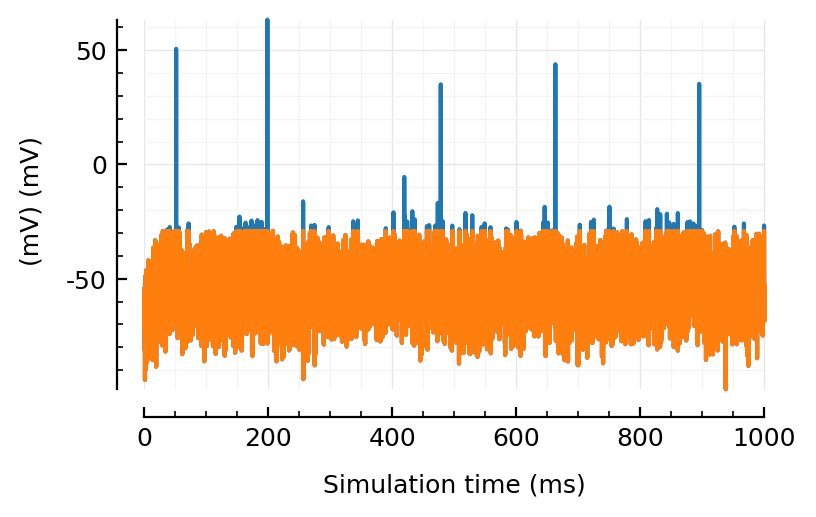

In [11]:
tlim=[0,1000]
plotsig(sig , tlim, ms, yunit=:mV)
plotsig(sigc, tlim, ms, yunit=:mV, yunits_in=nothing);

Hm, we might loose some non-spike signal there?  
So let's choose sth stricter:  (note that this is all for VI SNR 10, no systematic search.. But 10 is a realistic SNR, so, fine).

In [12]:
clip_pctile = 99.9
sigc = clip!(copy(sig), clip_pctile);

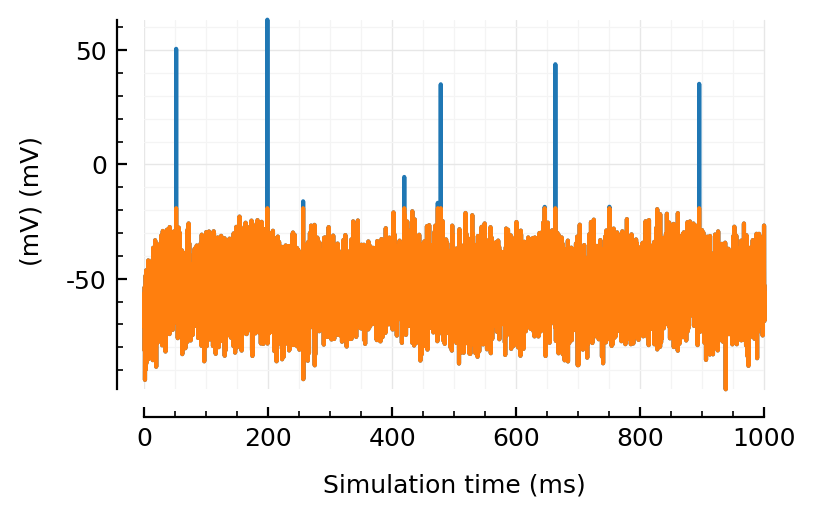

In [13]:
plotsig(sig , tlim, ms, yunit=:mV)
plotsig(sigc, tlim, ms, yunit=:mV, yunits_in=nothing);

Guess we could also set an absolute value, like clip at 0 or -20 mV or sth.\
But in VI recordings there is no scale.

Maybe there's some other way. Aren't those spikes bunched/clustered? yeah! i suppose they are..\
So we do.. uhm.. clustering on V distribution? I kinda like it..\
"Oja's algorithm"? ooooh yeah.\
no wait, that's sth else.\
But there is a similar sounding algorithm, used in quantization/discretization.\
Splitting sth (a distribution) in two..

**Otsu's method**!

https://github.com/mdhumphries/HierarchicalConsensusClustering/blob/master/Helper_Functions/otsu1D.m

## Test conns

In [14]:
cachedir = "2023-09-20__STA_conntest_for_diff_recording_quality_n_durations";

In [15]:
sim_ = CachedFunction(Nto1AdEx.sim, cachedir; disk=false, duration=10minutes, N)

CachedFunction(Nto1AdEx.sim, ThreadSafeDicts.ThreadSafeDict{Any, Any}(), false, true, "C:\\Users\\tfiers\\.julia\\MemDiskCache.jl\\2023-09-20__STA_conntest_for_diff_recording_quality_n_durations\\sim", Symbol[], Base.Pairs{Symbol, Real, Tuple{Symbol, Symbol}, NamedTuple{(:duration, :N), Tuple{Float64, Int64}}}(:duration => 600, :N => 6500))

In [16]:
MemDiskCache.set_dir(cachedir);

In [17]:
MemDiskCache.open_dir()

Process(`'C:\WINDOWS\system32\cmd.exe' /c start 'C:\Users\tfiers\.julia\MemDiskCache.jl\2023-09-20__STA_conntest_for_diff_recording_quality_n_durations'`, ProcessRunning)

In [20]:
function sim_and_test(; duration=10minutes, VI_SNR=Inf, seed=1)
    sim = sim_(; duration, seed)
    sig = VI_sig(sim, spike_SNR=VI_SNR)
    sigc = clip!(sig, clip_pctile)
    key = "sim_and_test" * string((; duration, VI_SNR, seed)) * "__rows"
    rows = @cached key test_high_firing_inputs(sim, sigc)
    # ↪ every row is a putative connection. (real type, t-val, presyn fr)
    df = DataFrame(rows)
    sweep = sweep_threshold(df)
    return (; sim, sigc, df, sweep)
end;

In [21]:
maxF1(sweep) = maximum(skipnan(sweep.F1));

↓ expected runtime: 8 SNRs x 5 seeds x 56 seconds = 37 minutes

In [22]:
SNRs = [Inf, 100, 40, 20, 10, 4, 2, 1];

In [47]:
rows = []
@time for VI_SNR in SNRs
    for seed in 1:5
        kw = (; duration, VI_SNR, seed)
        key = "sim_and_test$(kw)__sweep"
        row = @cached key begin
            (; sweep) = sim_and_test(; VI_SNR, seed)
            F1max = maxF1(sweep)
            (; AUC) = calc_AUROCs(sweep)
            row = (; VI_SNR, seed, F1max, AUC)
        end
        push!(rows, row)
        #println("\n", row, "\n"^2)
    end
end;

[ Info: Loading `sim_and_test(duration = 600, VI_SNR = Inf, seed = 1)__sweep` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = Inf, seed = 2)__sweep` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = Inf, seed = 3)__sweep` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = Inf, seed = 4)__sweep` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = Inf, seed = 5)__sweep` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 100, seed = 1)__sweep` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 100, seed = 2)__sweep` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 100, seed = 3)__sweep` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 100, seed = 4)__sweep` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 100, seed = 5)__sweep` from memory
[ Info: Loading `sim_and_test(duration = 600, VI_SNR = 40, seed = 1)__sweep` from memory
[ Info: Loa

In [48]:
df = df_snr = DataFrame(rows)
showsimple(df)

 VI_SNR  seed  F1max  AUC   
────────────────────────────
 Inf     1     0.829  0.796
 Inf     2     0.895  0.913
 Inf     3     0.851  0.834
 Inf     4     0.893  0.896
 Inf     5     0.838  0.859
 100     1     0.72   0.679
 100     2     0.794  0.78
 100     3     0.792  0.746
 100     4     0.812  0.789
 100     5     0.761  0.696
  40     1     0.604  0.455
  40     2     0.598  0.49
   ⋮      ⋮      ⋮      ⋮
   4     5     0.459  0.315
   2     1     0.398  0.233
   2     2     0.39   0.237
   2     3     0.451  0.292
   2     4     0.442  0.279
   2     5     0.447  0.306
   1     1     0.386  0.225
   1     2     0.375  0.227
   1     3     0.438  0.282
   1     4     0.424  0.264
   1     5     0.449  0.305
             17 rows omitted

Without clipping (from a first run, when I forgot to clip; only ceilin):
```
(VI_SNR = Inf, F1max = 0.697)
(VI_SNR = 10,  F1max = 0.469)
(VI_SNR = 4,   F1max = 0.404)
(VI_SNR = 2,   F1max = 0.398)
(VI_SNR = 1,   F1max = 0.390)
```
Note that, except at Inf snr, not much diff !

## Plot

In [50]:
fmt(x) = isinf(x) ? "∞" : round(Int, x);

In [130]:
plot_F1(df, xcol; ax=newax(), title=true, kw...) = begin
    plot_dots_and_means(df, xcol, :F1max; ax, ytype=:frac, color_means=C0, ylabel=nothing, kw...)
    deemph_middle_ticks(ax.yaxis)
    t = hylabel(ax, L"Maximum $F_1$-score (mean of Recall & Precision)")
    title && ax.annotate("Connection detection performance of STA test", fontweight="bold",
                         xy=(0, 1.3), xycoords=t, va="bottom")
    return ax
end;

In [52]:
xlabel = "Voltage imaging noise (spike-SNR)"
xticklabels=fmt.(SNRs);

Saved at `../thesis/figs/STA_perf_diff_snr_F1.pdf`

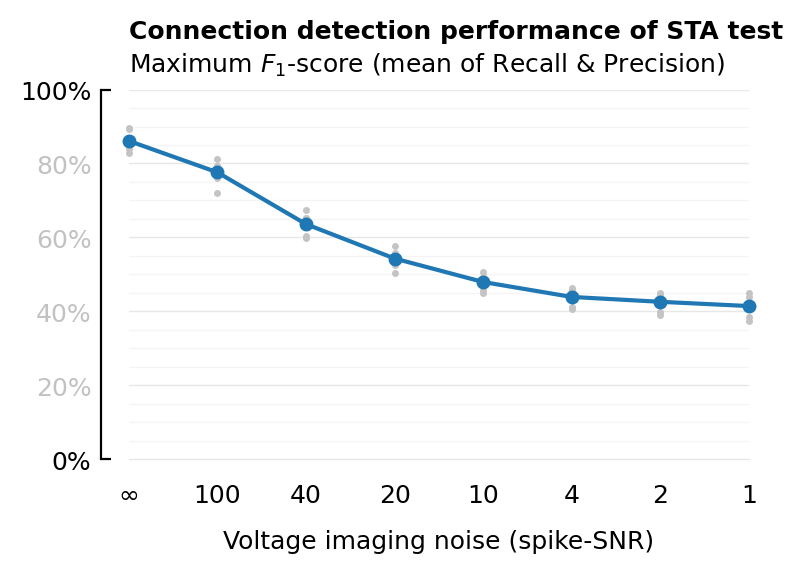

In [53]:
plot_F1(df_snr, :VI_SNR; xtype=:cat, xlabel, xticklabels);
savefig_phd("STA_perf_diff_snr_F1");

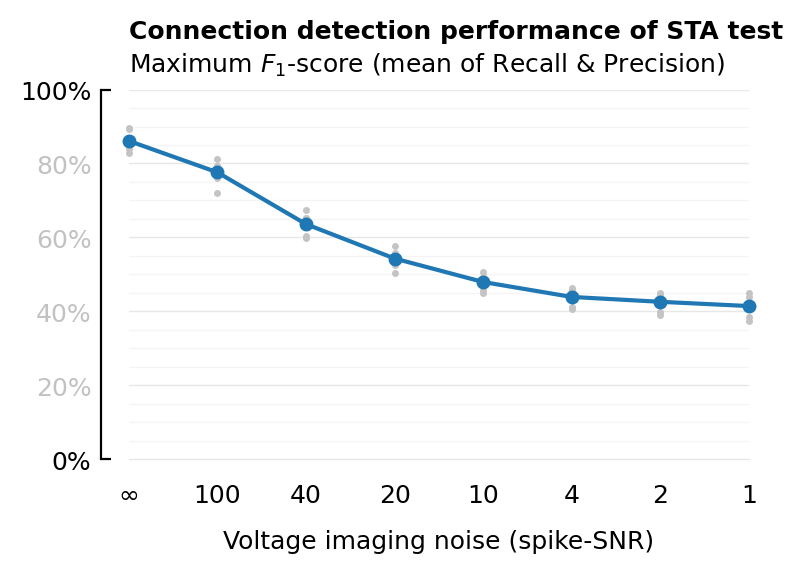

In [163]:
plot_F1(df_snr, :VI_SNR; xtype=:cat, xlabel, xticklabels);
# savefig_phd("STA_perf_diff_snr_F1");

In [131]:
plot_AUC(df, xcol; ax=newax(), chance_level_loc=:left, title=true, kw...) = begin
    color = "gray"
    chance_level = 0.252  # See section below :)
    l = ax.axhline(chance_level; lw=1, ls="--", color)
    if chance_level_loc == :left
        xy = (0,0)
        ha = "left"
    else
        xy = (1,0)
        ha = "right"
    end
    ax.annotate("Chance level"; xycoords=l, xy, ha, va="bottom", color)
    
    plot_dots_and_means(df, xcol, :AUC; ax, ylim=[0,1], ylabel=nothing, kw...)
    deemph_middle_ticks(ax.yaxis)
    t = hylabel(ax, "Area under ROC curve (AUC)");
    title && ax.annotate("Connection detection performance of STA test", fontweight="bold",
                         xy=(0, 1.3), xycoords=t, va="bottom");
    return ax
end;

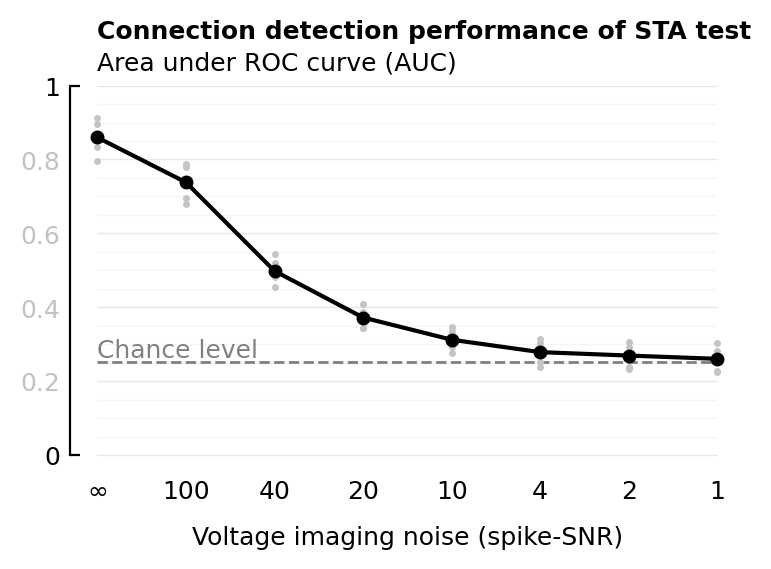

In [162]:
plot_AUC(df_snr, :VI_SNR; xtype=:cat, xticklabels, xlabel);
# savefig_phd("STA_perf_diff_snr_auc");

One fig. Tighter ylims.

Saved at `../thesis/figs/STA_perf_diff_snr.pdf`

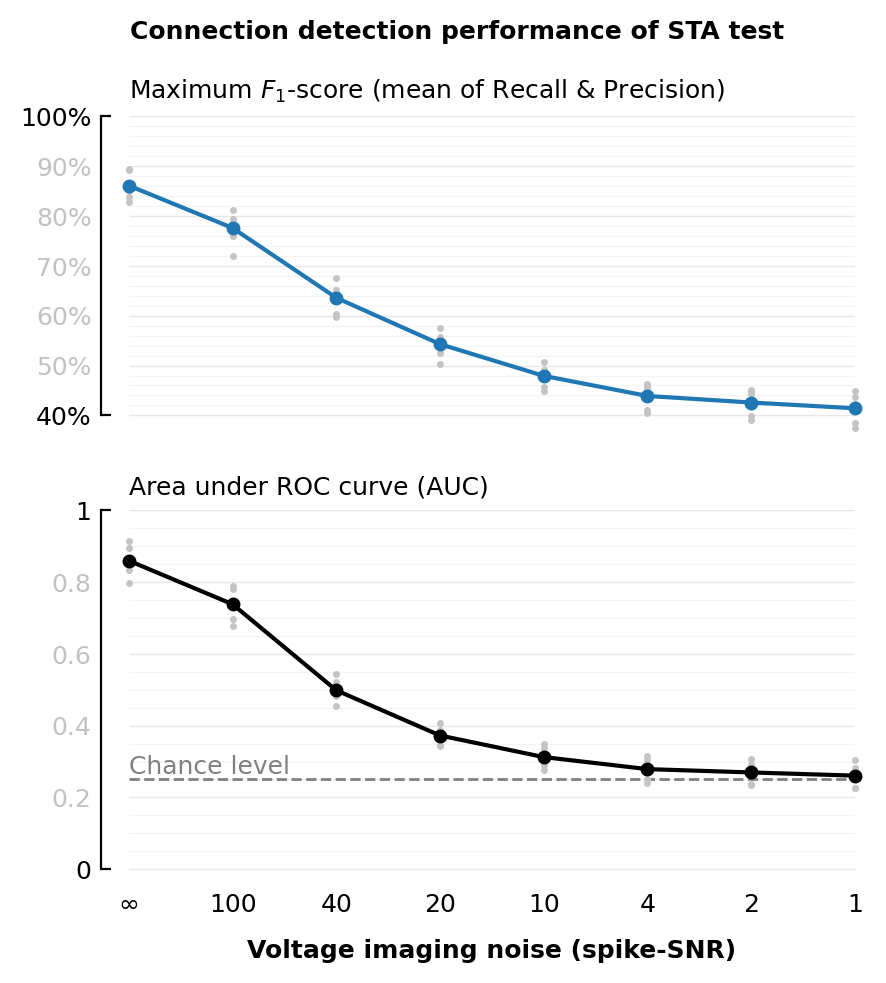

In [184]:
fig, (ax_top, ax_btm) = plt.subplots(nrows=2, figsize=(mtw,1.1mtw), height_ratios=[1,1.2])
xlabel = ("Voltage imaging noise (spike-SNR)", :fontweight=>"bold")
xticklabels=fmt.(SNRs)
plot_F1(df_snr, :VI_SNR; xtype=:cat, ylim=[0.4, 1], ax=ax_top, title=false, xlabel=nothing)
rm_ticks_and_spine(ax_top, "bottom")
plot_AUC(df_snr, :VI_SNR; xtype=:cat, ylim=[0, 1], ax=ax_btm, title=false, xlabel, xticklabels);
fig.suptitle("Connection detection performance of STA test", x=0.5155)
plt.tight_layout(h_pad=1.7);
savefig_phd("STA_perf_diff_snr");

## Comparing AUC and F1max directly.

In [61]:
gd = groupby(df_snr, :VI_SNR)
dfm = combine(gd, [:F1max, :AUC] .=> mean, renamecols=false)

Row,VI_SNR,F1max,AUC
,Float64,Float64,Float64
1,Inf,0.861,0.86
2,100,0.776,0.738
3,40,0.636,0.498
4,20,0.543,0.372
5,10,0.479,0.312
6,4,0.439,0.279
7,2,0.426,0.269
8,1,0.414,0.261


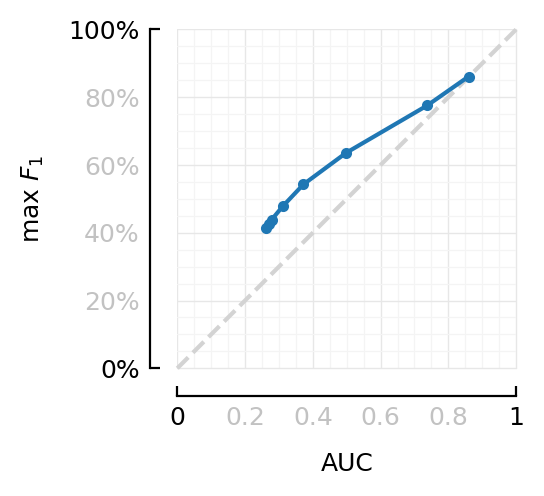

In [64]:
ax=newax(figsize=(2.2, 2.2));
plot([0,1], [0,1], "--"; ax, c="lightgrey")
plot(dfm.AUC, dfm.F1max, ".-"; ax, aspect="equal", xlim=[0,1], ylim=[0,1],
     xlabel="AUC", ylabel=L"\max\ F_1", ytype=:fraction);
deemph_middle_ticks(ax);

## Longer recording

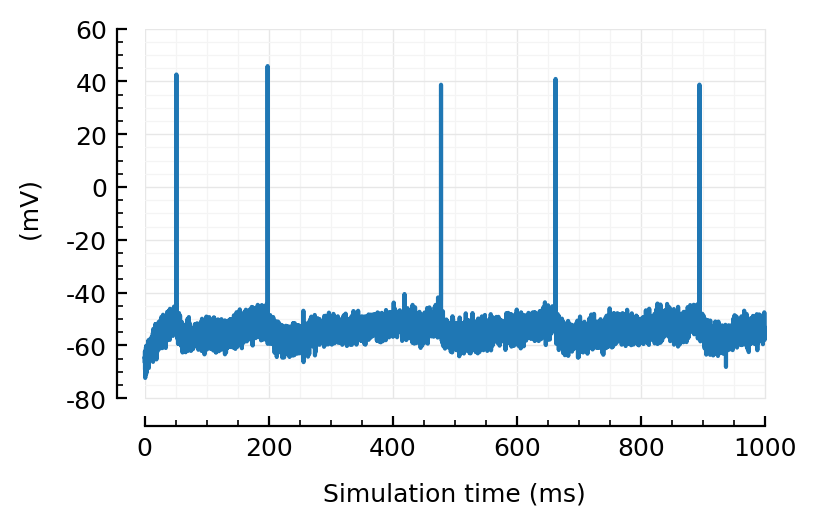

In [65]:
plotsig(VI_sig(sim; spike_SNR=40), tlim, ms, yunit=:mV);

Sure, I can see that happening.

In [67]:
out = @cached "longer_rec" sim_and_test(duration=60minutes, VI_SNR=40);

[ Info: Loading `longer_rec` from memory


In [68]:
(; sweep) = out
maxF1(sweep)

0.879

In [69]:
calc_AUROCs(sweep)

(AUC = 0.893, AUCₑ = 0.821, AUCᵢ = 0.966)

## Chance level

What is AUROC chance level for our weird ternary classification.

Assign classes randomly. Or rather give random connectedness-scores (t-vals).

In [70]:
random_test_result(Nₜ = 100) = begin
    conntype = repeat([:exc, :inh, :unc], inner=Nₜ)
    N = length(conntype)
    t = 2*rand(N) .- 1  # Uniform in [-1, 1]
    df = DataFrame(; conntype, t)
end

for _ in 1:5
    df = random_test_result()
    sweep = sweep_threshold(df)
    println(calc_AUROCs(sweep))
end

(AUC = 0.247, AUCₑ = 0.302, AUCᵢ = 0.192)
(AUC = 0.305, AUCₑ = 0.328, AUCᵢ = 0.282)
(AUC = 0.251, AUCₑ = 0.234, AUCᵢ = 0.268)
(AUC = 0.208, AUCₑ = 0.192, AUCᵢ = 0.224)
(AUC = 0.224, AUCₑ = 0.225, AUCᵢ = 0.224)


So chance level is even less than 0.333

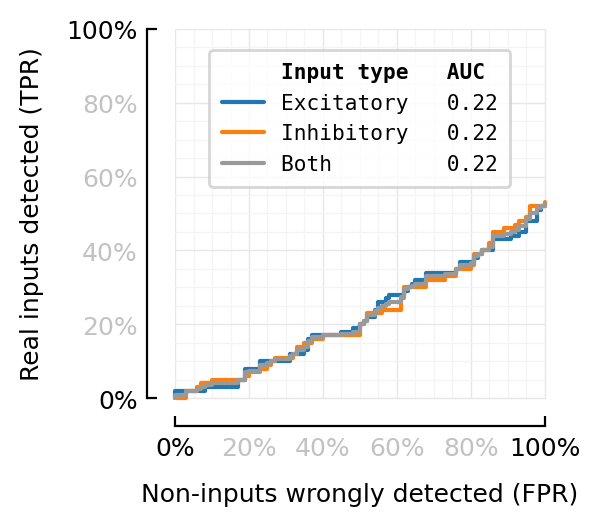

In [71]:
ax = plotROC(sweep, legend_loc="upper center")
deemph_middle_ticks(ax);

In [72]:
random_test_AUC() = calc_AUROCs(sweep_threshold(random_test_result())).AUC
@time random_test_AUC()

  0.029802 seconds (72.67 k allocations: 11.245 MiB)


0.266

In [89]:
rm_from_memcache!("random_test_AUCs")
rm_from_disk("random_test_AUCs")

In [90]:
Random.seed!(1234)
random_test_AUCs = @cached "random_test_AUCs" [random_test_AUC() for _ in 1:300];

Running `[random_test_AUC() for _ = 1:300]` with key `random_test_AUCs` … 
Running `[random_test_AUC() for _ = 1:300]` with key `random_test_AUCs` ✔ (9.1 s)
Saving output at [C:\Users\tfiers\.julia\MemDiskCache.jl\2023-09-20__STA_conntest_for_diff_recording_quality_n_durations\random_test_AUCs.jld2] … ✔


(4 seconds)

In [91]:
(; ConnectionPatch) = mpl.patches;

function connect(axA, axB, xyA, xyB=xyA; lw=0.8, ls="--", color=Gray(0.4), kw...)
    fig = axA.figure
    con = ConnectionPatch(xyA, xyB, axA.transData, axB.transData; lw, ls, color=toRGBAtuple(color), kw...)
    fig.add_artist(con)
end;

Saved at `../thesis/figs/AUC_chance_level.pdf`

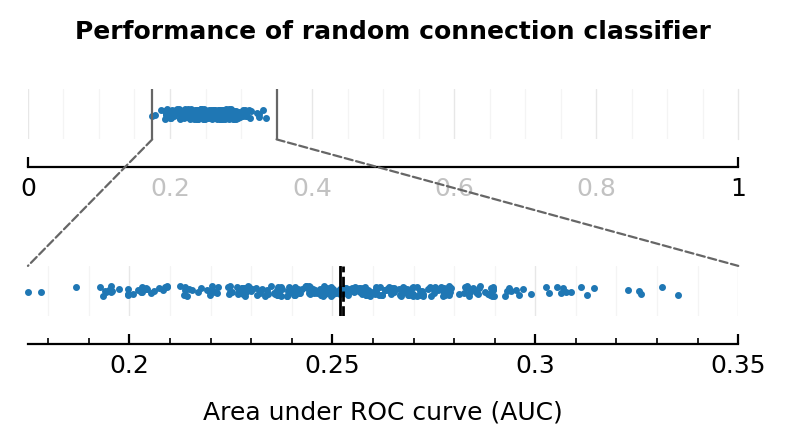

In [92]:
fig, (ax_top, ax_btm) = plt.subplots(nrows=2, figsize=(4, 2.2))
distplot(random_test_AUCs; ax=ax_top, xlim=[0, 1], lines=false)
distplot(random_test_AUCs; ax=ax_btm, xlabel="Area under ROC curve (AUC)")
deemph_middle_ticks(ax_top)
xl, xr = ax_btm.get_xlim()
yb, yt = ax_top.get_ylim()
connect(ax_top, ax_btm, (xl, yb), (xl, yt))
connect(ax_top, ax_btm, (xr, yb), (xr, yt))
ax_top.vlines([xl, xr], yb, yt, color=toRGBAtuple(Gray(0.4)), lw=0.8)
fig.suptitle("Performance of random connection classifier")
plt.tight_layout(h_pad=2.6);
savefig_phd("AUC_chance_level")

In [123]:
random_test_maxF1() = maxF1(sweep_threshold(random_test_result()))
random_test_maxF1()

0.375

In [124]:
Random.seed!(1234)
random_test_F1s = @cached "random_test_F1s" [random_test_maxF1() for _ in 1:300];

Running `[random_test_maxF1() for _ = 1:300]` with key `random_test_F1s` … 
Running `[random_test_maxF1() for _ = 1:300]` with key `random_test_F1s` ✔ (32.8 s)
Saving output at [C:\Users\tfiers\.julia\MemDiskCache.jl\2023-09-20__STA_conntest_for_diff_recording_quality_n_durations\random_test_F1s.jld2] … ✔


In [126]:
mean(random_test_F1s), median(random_test_F1s)

(0.403, 0.404)

## Vary recording duration

In [20]:
durations = [10seconds, 30seconds, 1minute, 2minutes, 4minutes, 10minutes, 20minutes, 30minutes, 1hour]
VI_SNR = 40;

In [104]:
rows = []
@time for duration in durations
    for seed in 1:5
        kw = (; VI_SNR, duration, seed)
        key = "sim_and_test$(kw)__sweep_row"
        row = @cached key begin
            (; sweep) = sim_and_test(; kw...)
            F1max = maxF1(sweep)
            (; AUC) = calc_AUROCs(sweep)
            row = (; duration, seed, F1max, AUC)
        end
        push!(rows, row)
        # println("\n", row, "\n"^2)
    end
end;

[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 10, seed = 1)__sweep_row` from memory
[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 10, seed = 2)__sweep_row` from memory
[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 10, seed = 3)__sweep_row` from memory
[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 10, seed = 4)__sweep_row` from memory
[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 10, seed = 5)__sweep_row` from memory
[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 30, seed = 1)__sweep_row` from memory
[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 30, seed = 2)__sweep_row` from memory
[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 30, seed = 3)__sweep_row` from memory
[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 30, seed = 4)__sweep_row` from memory
[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 30, seed = 5)__sweep_row` from memory
[ Info: Loading `sim_and_test(VI_SNR = 40, duration = 60, seed = 1)__sweep_row` 

Running all this took:

In [510]:
6687.8 / minutes

111

Holy damn, discovered a bug.\
(For 10second duration: exc and inh test instant, but uncon suspiciously slow).\
Reason: in `get_trains_to_test` (from `lib/Nto1.jl`), `duration` is a global var.\
[This is one discovered disadvantage of a script vs a module!! Name leakage vs encapsulation].

ok, turned out this didn't have an effect on the results. good.

In [108]:
df = df_duration = DataFrame(rows)
df.duration = df.duration / minutes
df

Row,duration,seed,F1max,AUC
,Float64,Int64,Float64,Float64
1,0.167,1,0.46,0.303
2,0.167,2,0.45,0.276
3,0.167,3,0.454,0.291
4,0.167,4,0.447,0.296
5,0.167,5,0.417,0.267
⋮,⋮,⋮,⋮,⋮
41,60,1,0.879,0.893
42,60,2,0.886,0.891
43,60,3,0.867,0.862


In [26]:
xscale = "log"
xlabel = "Recording duration"
xticklabels = ["6 sec", "1 min", "10 min", "1 hr 40"]
kw = (; xscale, xlabel, xticklabels);

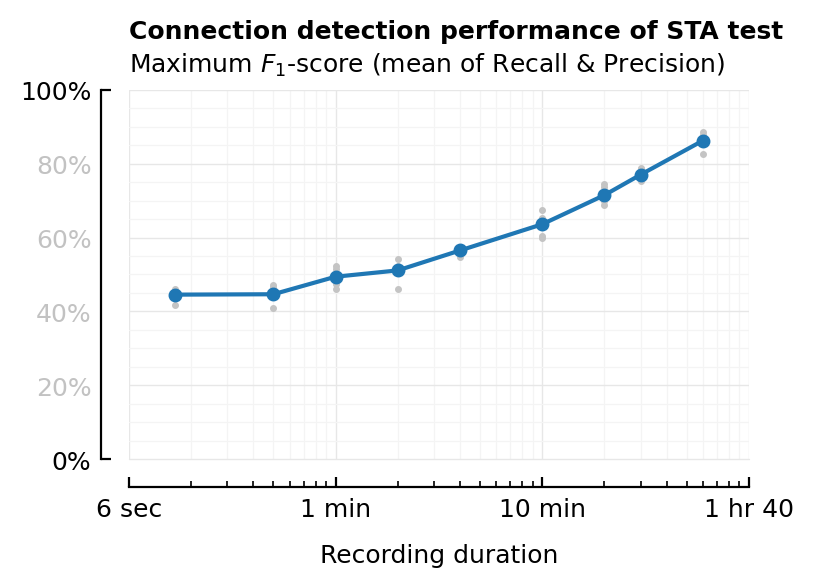

In [176]:
plot_F1(df_duration, :duration; kw...);
# savefig_phd("STA_perf_diff_dur_F1")

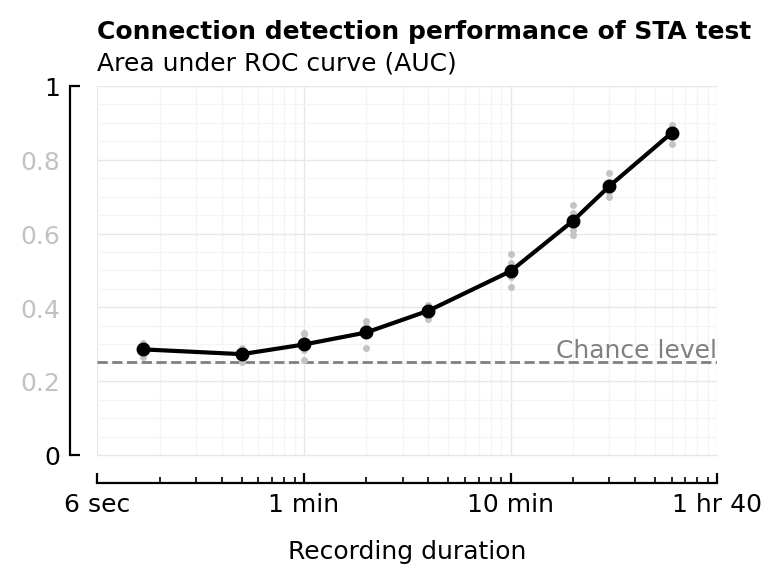

In [177]:
plot_AUC(df_duration, :duration; kw..., chance_level_loc=:right);
# savefig_phd("STA_perf_diff_dur_auc")

Saved at `../thesis/figs/STA_perf_diff_rec_duration.pdf`

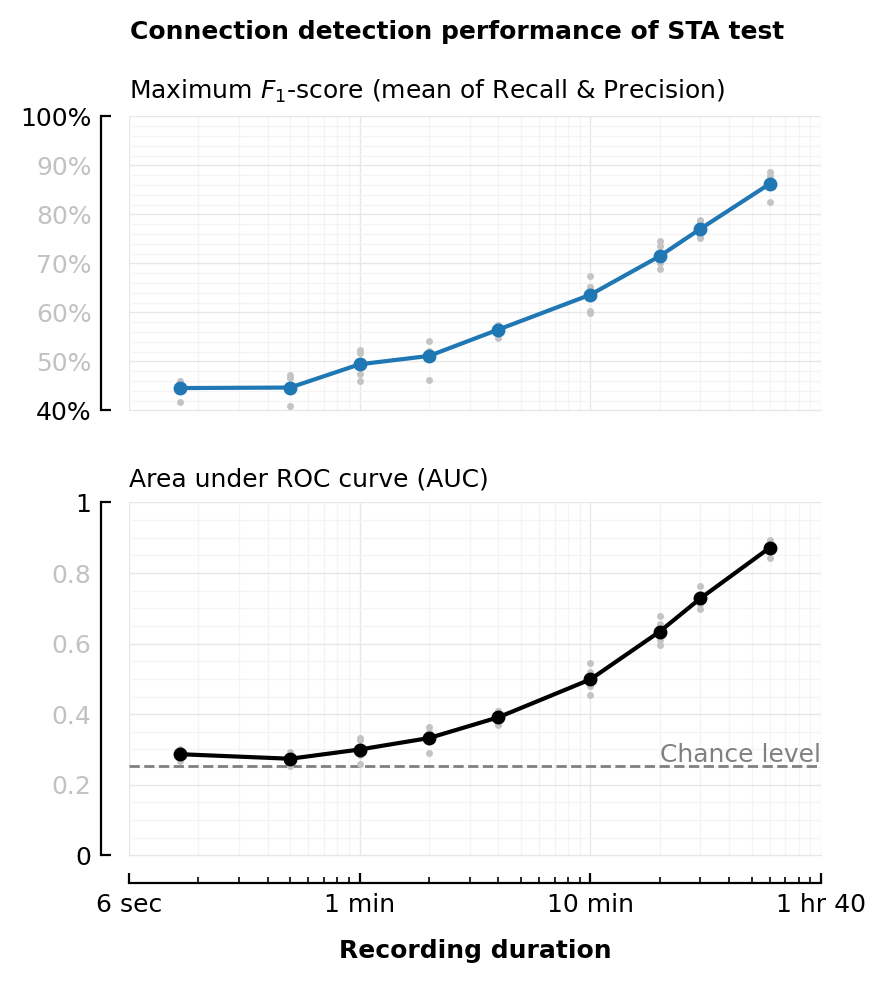

In [186]:
xlabel = ("Recording duration", :fontweight=>"bold")
xscale = "log"
xticklabels = ["6 sec", "1 min", "10 min", "1 hr 40"]
fig, (ax_top, ax_btm) = plt.subplots(nrows=2, figsize=(mtw,1.1mtw), height_ratios=[1,1.2])
plot_F1(df_duration, :duration; xscale, ylim=[0.4, 1], ax=ax_top, title=false, xlabel=nothing)
rm_ticks_and_spine(ax_top, "bottom")
plot_AUC(df_duration, :duration;
         ylim=[0, 1], ax=ax_btm, title=false, xscale, xlabel, xticklabels, chance_level_loc=:right);
fig.suptitle("Connection detection performance of STA test", x=0.5155)
plt.tight_layout(h_pad=1.7);
savefig_phd("STA_perf_diff_rec_duration");

## Computation time

Read out from cache files on disk.

In [21]:
VI_SNR = 40;
rows = []
@time for duration in durations
    for seed in 1:5
        key = "sim_and_test" * string((; duration, VI_SNR, seed)) * "__rows"
        runtime = get_runtime(key)
        row = (; duration, seed, runtime)
        push!(rows, row)
        # println("\n", row, "\n"^2)
    end
end;

  2.007167 seconds (2.14 M allocations: 127.208 MiB, 1.46% gc time)


In [35]:
df = df_runtimes = DataFrame(rows)
rename!(df, :duration => :sim_duration)
df.sim_duration .= df.sim_duration / minutes
df.runtime .= df.runtime / minutes

dfm = combine(groupby(df, :sim_duration), :runtime => mean => :runtime)

Row,sim_duration,runtime
,Float64,Float64
1,0.167,0.0299
2,0.5,0.0679
3,1,0.134
4,2,0.316
5,4,0.68
6,10,1.68
7,20,3.36
8,30,5.07
9,60,10.8


In [33]:
using Printf

fmt((x,y)::NTuple{2, Float64}) = fmt(fmt(x), fmt(y))
fmt(x::String, y::String) = "($x → $y)"
fmt(minutes::Float64) = (
    minutes < 1   ?  str(60*minutes) * " sec"  :
    minutes ≥ 60  ?  str(minutes/60) * " hr"   :
                     str(minutes)    * " min"
)
str(num) = @sprintf "%.2g" num;

Saved at `../thesis/figs/STA_compute_time.pdf`

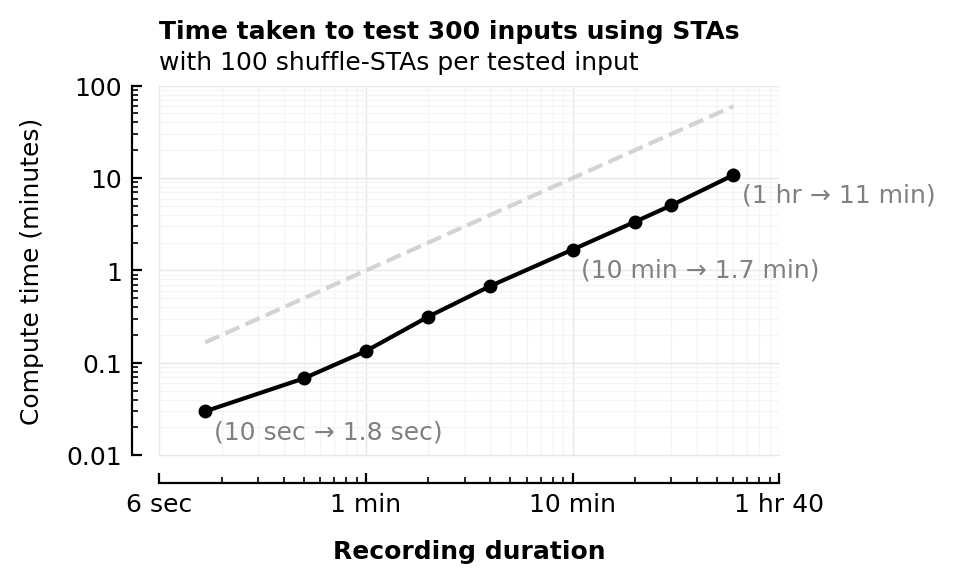

In [45]:
ax = newax()
x1 = df.sim_duration[1]
x2 = df.sim_duration[end]
ax.plot([x1,x2], [x1,x2], "--", c="lightgray");
plot_dots_and_means(
    df_runtimes, :sim_duration, :runtime; xscale="log", yscale="log", ax,
    xticklabels,
    xlabel = (xlabel, :fontweight => "bold"),
    ylabel = "Compute time (minutes)",
)
xy(i) = (dfm.sim_duration[i], dfm.runtime[i])
ax.annotate(xy=xy(1), text=fmt(xy(1)), va="top", textcoords="offset points", xytext=(3, -3), color="gray")
ax.annotate(xy=xy(6), text=fmt(xy(6)), va="top", textcoords="offset points", xytext=(3, -3), color="gray")
ax.annotate(xy=xy(9), text=fmt(xy(9)), va="top", textcoords="offset points", xytext=(3, -3), color="gray")
axtitle(ax,
    "Time taken to test 300 inputs using STAs",
    "with 100 shuffle-STAs per tested input",
)
savefig_phd("STA_compute_time")